<h3>Définition</h3>
Les séquences de mots (phrases) sont classées en catégories ou étiquettes spécifiques.
Chaque mot dans une phrase est étiqueté avec une classe correspondant à son rôle, sa partie du discours, ou toute autre catégorie pertinente.
Le modèle tente de prédire la séquence d'étiquettes pour chaque séquence de mots.
Ainsi, bien que cela ne soit pas une classification classique de documents ou d'images, le problème est une forme de classification de séquences de mots, ce qui constitue une tâche de classification dans le contexte du traitement du langage naturel.

 <h3>La pondération des classes</h3> est une méthode simple et efficace pour traiter le déséquilibre de classes

<h3>Importation des bibliothèques nécessaires</h3>

In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

from collections import Counter
import joblib

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Bidirectional, Embedding, LSTM, Dense

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


2024-03-02 10:26:07.698107: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-02 10:26:10.645648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 10:26:10.645744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 10:26:10.666764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 10:26:12.033482: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-02 10:26:12.035501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

<h3>Chargement des données & Tokenisation des phrases</h3>

In [2]:
start = time.time()
file_path = '/home/vatosoa/mg-smart-lingua-discover/data/corpus/sokajinteny.csv'
df = pd.read_csv(file_path)

# Colonnes 'Fehezanteny' et 'Sokajinteny' sont remplies ?
df['Fehezanteny'].fillna('', inplace=True)
df['Sokajinteny'].fillna('', inplace=True)

# Fonction de tokenisation de mots
def tokenize_words(text):
    if isinstance(text, str):
        language = detect(text)
        text = re.sub(r'[-;:()?!,.\'"\/|]', ' ', text)
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if token.isalnum()]
        return tokens
    else:
        return []

# Appliquer la tokenisation aux phrases et créer une colonne pour les tokens
df['Fehezanteny_tokens'] = df['Fehezanteny'].apply(tokenize_words)

# Associer chaque token à son étiquette correspondante
df['Sokajinteny_tokens'] = df['Sokajinteny'].apply(lambda x: x.split())


In [3]:
df['Sokajinteny_tokens']

0       [Mpampiankina, Mpanoritra, Tambinteny, Anarana...
1       [Mpampitohy, Mpanoritra, Anarana, Matoanteny, ...
2       [Mpampitohy, Mpanoritra, Anarana, Anarana, Mat...
3       [Mpampitohy, Anarana, Matoanteny, Tambinteny, ...
4       [Mpampitohy, Matoanteny, Anarana, Tambinteny, ...
                              ...                        
1164    [Kianteny, Matoanteny, Kianteny, Anarana, Kian...
1165    [Mpampitohy, Mpampitohy, Matoanteny, Mpisolo, ...
1166    [Mpampitohy, Anarana, Matoanteny, Matoanteny, ...
1167    [Mpampitohy, Anarana, Matoanteny, Tambinteny, ...
1168    [Mpampitohy, Matoanteny, Mpanoritra, Anarana, ...
Name: Sokajinteny_tokens, Length: 1169, dtype: object

<h3>Préparation des données d'entrainement et de test</h3>

In [4]:
# Étape 1 : Création des jeux de données d'entraînement et de test
X = df['Fehezanteny_tokens'].values
y = df['Sokajinteny_tokens'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h3>Encodage des tokens et des étiquettes</h3>

In [5]:
# Étape 2-3 : Encodage des tokens et des étiquettes
token_encoder = LabelEncoder()
label_encoder = LabelEncoder()

# Adapter les encodeurs aux données d'entraînement pour les tokens et les étiquettes
token_encoder.fit(df['Fehezanteny_tokens'].explode())
label_encoder.fit(df['Sokajinteny_tokens'].explode())

# Fonction pour encoder une séquence de tokens
def encode_sequence(seq, encoder):
    return [encoder.transform([token])[0] for token in seq]

# Encodage des séquences de tokens
X_train_encoded = [encode_sequence(seq, token_encoder) for seq in X_train]
X_test_encoded = [encode_sequence(seq, token_encoder) for seq in X_test]

# Trouver la longueur maximale de séquence après l'encodage
max_sequence_length = max(len(seq) for seq in X_train_encoded + X_test_encoded)

# Remplissage des séquences
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_sequence_length, padding='post')

# Encodage des étiquettes
y_train_encoded = [encode_sequence(seq, label_encoder) for seq in y_train]
y_test_encoded = [encode_sequence(seq, label_encoder) for seq in y_test]

# Remplissage des étiquettes
y_train_padded = pad_sequences(y_train_encoded, maxlen=max_sequence_length, padding='post')
y_test_padded = pad_sequences(y_test_encoded, maxlen=max_sequence_length, padding='post')


<h1>Liste de tous les étiquettes</h1>

In [6]:
# Obtenez toutes les étiquettes uniques dans le corpus
all_labels = label_encoder.classes_

# Affichez la liste des étiquettes
print("Liste des étiquettes dans le corpus:")
for label in all_labels:
    print(label)

Liste des étiquettes dans le corpus:
Anarana
Kianteny
Matoanteny
Mpamaritra
Mpampiankina
Mpampitohy
Mpanoritra
Mpisolo
Tambinteny
Tenim-piotanana
nan


<h3>Voir tous les longueurs du feature et tagset</h3>

In [7]:
# Ajouter la longueur des tokens de Fehezanteny_tokens et Sokajinteny_tokens à chaque ligne
df['Fehezanteny_tokens_length'] = df['Fehezanteny_tokens'].apply(lambda x: len(x))
df['Sokajinteny_tokens_length'] = df['Sokajinteny_tokens'].apply(lambda x: len(x))

# Afficher les lignes où il n'y a pas d'étiquette 'nan'
for index, row in df.iterrows():
    if 'nan' not in row['Sokajinteny_tokens']:
        print(f"Ligne {index}:")
        print("Fehezanteny tokens:", row['Fehezanteny_tokens'])
        print("Longueur des tokens Fehezanteny:", row['Fehezanteny_tokens_length'])
        print("Sokajinteny tokens:", row['Sokajinteny_tokens'])
        print("Longueur des tokens Sokajinteny:", row['Sokajinteny_tokens_length'])
        print()


Ligne 0:
Fehezanteny tokens: ['tamin', 'ny', 'voalohany', 'andriamanitra', 'nahary', 'ny', 'lanitra', 'sy', 'ny', 'tany']
Longueur des tokens Fehezanteny: 10
Sokajinteny tokens: ['Mpampiankina', 'Mpanoritra', 'Tambinteny', 'Anarana', 'Matoanteny', 'Mpanoritra', 'Anarana', 'Mpampitohy', 'Mpanoritra', 'Anarana']
Longueur des tokens Sokajinteny: 10

Ligne 1:
Fehezanteny tokens: ['ary', 'ny', 'tany', 'dia', 'tsy', 'nisy', 'endrika', 'sady', 'foana', 'ary', 'aizina', 'no', 'tambonin', 'ny', 'lalina']
Longueur des tokens Fehezanteny: 15
Sokajinteny tokens: ['Mpampitohy', 'Mpanoritra', 'Anarana', 'Matoanteny', 'Tambinteny', 'Matoanteny', 'Anarana', 'Mpampitohy', 'Mpamaritra', 'Mpampitohy', 'Matoanteny', 'Kianteny', 'Tambinteny', 'Mpanoritra', 'Mpamaritra']
Longueur des tokens Sokajinteny: 15

Ligne 2:
Fehezanteny tokens: ['ary', 'ny', 'fanahin', 'andriamanitra', 'nanomba', 'tambonin', 'ny', 'rano']
Longueur des tokens Fehezanteny: 8
Sokajinteny tokens: ['Mpampitohy', 'Mpanoritra', 'Anarana', 

<h3>voir si feature =! tagset --> nan variable</h3>

In [8]:
# Afficher les lignes où la longueur des tokens de Fehezanteny_tokens n'est pas égale à la longueur des tokens de Sokajinteny_tokens
for index, row in df.iterrows():
    if len(row['Fehezanteny_tokens']) != len(row['Sokajinteny_tokens']):
        print(f"Ligne {index}:")
        print("Fehezanteny tokens:", row['Fehezanteny_tokens'])
        print("Longueur des tokens Fehezanteny:", row['Fehezanteny_tokens_length'])
        print("Sokajinteny tokens:", row['Sokajinteny_tokens'])
        print("Longueur des tokens Sokajinteny:", row['Sokajinteny_tokens_length'])
        print()


Ligne 406:
Fehezanteny tokens: ['ary', 'ny', 'lehilahy', 'rehetra', 'tao', 'an', 'tranony', 'dia', 'ny', 'ompikely', 'mbamin', 'izay', 'novidim', 'bola', 'tamin', 'ny', 'hafa', 'firenena', 'dia', 'samy', 'niara', 'noforana', 'taminy', 'avokoa']
Longueur des tokens Fehezanteny: 24
Sokajinteny tokens: ['Mpampitohy', 'Mpanoritra', 'Mpamaritra', 'Tambinteny', 'Tambinteny', 'Anarana', 'Kianteny', 'Mpanoritra', 'Anarana', 'Mpampiankina', 'Mpisolo', 'Matoanteny', 'Anarana', 'Mpampiankina', 'Mpanoritra', 'Mpamaritra', 'Anarana', 'Kianteny', 'Mpisolo', 'Matoanteny', 'Matoanteny', 'Mpampiankina', 'Mpamaritra']
Longueur des tokens Sokajinteny: 23

Ligne 408:
Fehezanteny tokens: ['aoka', 'hangalana', 'rano', 'kely', 'ianareo', 'hanasana', 'ny', 'tongotrareo', 'ary', 'aoka', 'mba', 'hiala', 'sasatra', 'kely', 'eo', 'am', 'pototry', 'ny', 'hazo', 'ianareo', 'dia', 'haka', 'mofo', 'kely', 'aho', 'hataonareo', 'ody', 'am', 'bavafo', 'ary', 'rehefa', 'afaka', 'izany', 'dia', 'handeha', 'ihany', 'ianare

<h3>Calcul des poids de classe inverses</h3>

In [9]:
# Compter la fréquence des étiquettes dans les données d'entraînement
label_freq = Counter(y_train_padded.flatten())

# Calculer les poids de classe inverses en fonction de la fréquence
total_samples = len(y_train_padded.flatten())
class_weights = {cls: total_samples / label_freq[cls] for cls in label_freq}


<h3>Création du modèle LSTM</h3>

In [10]:
# Création du modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=len(token_encoder.classes_), output_dim=64, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128, return_sequences=True))) # Retourne les séquences pour chaque token
model.add(Dense(len(label_encoder.classes_), activation='softmax')) # Couche Dense pour chaque token

# Compilation du modèle en utilisant sample_weight_mode
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'], sample_weight_mode=class_weights)


<h3>Entraînement du modèle</h3>

In [11]:
# Entraînement du modèle en utilisant les données d'entraînement et de validation
# Récupérer l'historique de l'entraînement
history = model.fit(X_train_padded, y_train_padded, epochs=50, batch_size=32, validation_data=(X_test_padded, y_test_padded))


Epoch 1/50
30/30 [==============================] - 28s 578ms/step - loss: 1.1121 - accuracy: 0.7932 - val_loss: 0.5885 - val_accuracy: 0.8293
Epoch 2/50
30/30 [==============================] - 16s 524ms/step - loss: 0.5604 - accuracy: 0.8197 - val_loss: 0.5071 - val_accuracy: 0.8293
Epoch 3/50
30/30 [==============================] - 19s 624ms/step - loss: 0.5225 - accuracy: 0.8197 - val_loss: 0.4854 - val_accuracy: 0.8298
Epoch 4/50
30/30 [==============================] - 16s 510ms/step - loss: 0.5052 - accuracy: 0.8201 - val_loss: 0.4688 - val_accuracy: 0.8295
Epoch 5/50
30/30 [==============================] - 18s 597ms/step - loss: 0.4851 - accuracy: 0.8220 - val_loss: 0.4472 - val_accuracy: 0.8320
Epoch 6/50
30/30 [==============================] - 18s 616ms/step - loss: 0.4548 - accuracy: 0.8349 - val_loss: 0.4109 - val_accuracy: 0.8538
Epoch 7/50
30/30 [==============================] - 26s 891ms/step - loss: 0.4013 - accuracy: 0.8717 - val_loss: 0.3473 - val_accuracy: 0.9064

<h3>Visualisation des courbes Pertes et Précision</h3>

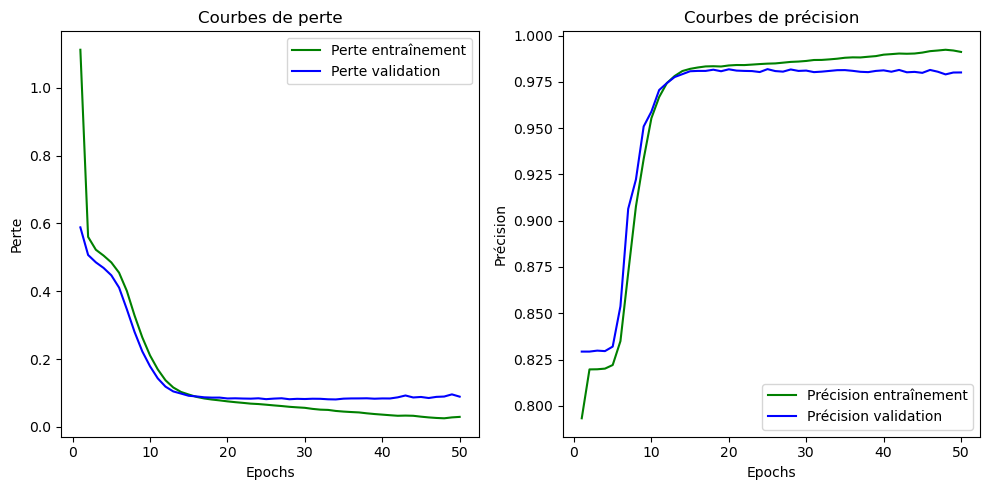

In [12]:
import matplotlib.pyplot as plt


# Extraire les valeurs de précision et de perte de l'entraînement et de la validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Tracer les courbes de perte
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'g', label='Perte entraînement')
plt.plot(epochs, val_loss, 'b', label='Perte validation')
plt.title('Courbes de perte')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()

# Tracer les courbes de précision
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'g', label='Précision entraînement')
plt.plot(epochs, val_accuracy, 'b', label='Précision validation')
plt.title('Courbes de précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


<strong>Courbe de perte :</strong>

- Diminution de la perte d'entraînement sur les epochs, signe d'amélioration du modèle sur les données d'entraînement.
- Attention à l'augmentation de la perte de validation alors que la perte d'entraînement diminue, indiquant un possible surajustement.


<strong>Courbe de précision :</strong>

- Augmentation de la précision d'entraînement et de validation, indiquant l'apprentissage du modèle.
- Stabilité ou augmentation de la précision de validation est positif. Attention à une diminution, suggérant un possible surajustement ou une difficulté à généraliser.


<h3>Évaluation du modèle</h3>

<h4>Perte et Précision</h4>

In [13]:
# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(X_test_padded, y_test_padded)
# Affichage des résultats
print(f"Perte (Loss) sur les données de test : {loss}")
print(f"Précision (Accuracy) sur les données de test : {accuracy}")
print(f"Test accuracy: {accuracy * 100:.2f}%")


8/8 [==============================] - 3s 313ms/step - loss: 0.0894 - accuracy: 0.9801
Perte (Loss) sur les données de test : 0.08936112374067307
Précision (Accuracy) sur les données de test : 0.9800715446472168
Test accuracy: 98.01%


<h4>F1-score et Matrice de confusion</h4>

In [14]:
# Étape 9 : Autres métriques d'évaluation (F1-score, matrice de confusion, etc.)

from sklearn.metrics import f1_score, confusion_matrix

# Prédictions du modèle sur les données de test
predictions = model.predict(X_test_padded)
predicted_labels = np.argmax(predictions, axis=-1)

# Calcul du F1-score
f1 = f1_score(y_test_padded.flatten(), predicted_labels.flatten(), average='weighted')
print(f"F1-score : {f1}")

# Calcul de la matrice de confusion
confusion = confusion_matrix(y_test_padded.flatten(), predicted_labels.flatten())
print("Matrice de confusion :")
print(confusion)


8/8 [==============================] - 7s 289ms/step
F1-score : 0.9799382679905193
Matrice de confusion :
[[18923     8    41     8     5     1    11    10    10     0]
 [    5   441     5     4     1    11     2     4     7     0]
 [   89     8   598    12     2     0     4     2    10     0]
 [   13     6     7   257     1     1     2     1     9     0]
 [    4     2     3     0   217     2     0     5     8     0]
 [    1    18     1     3     1   452     2     0     2     0]
 [    6     0     0     2     2     4   590     2     1     0]
 [    7     2     7     4    11     0     1   474     4     0]
 [   12    14     4     8     1     0     2     3   509     4]
 [    0     0     1     0     0     0     0     0     3    14]]


<h4>F1-score</h4>

In [15]:
from sklearn.metrics import f1_score

# Prédictions du modèle
predictions = model.predict(X_test_padded)
predicted_labels = np.argmax(predictions, axis=-1)

# Calcul du F1-score
f1 = f1_score(y_test_padded.flatten(), predicted_labels.flatten(), average='weighted')
print(f"F1-score: {f1}")


8/8 [==============================] - 3s 331ms/step
F1-score: 0.9799382679905193


<h3>Prédictions sur de nouvelles phrases</h3>

In [16]:
nouvelles_phrases = [
    "Hitan'Andriamanitra fa tsara.",
    "Mandeha i Josefa."
    #"Tsara ny nanao izao tany izao."
    # Ajoutez autant de phrases que vous le souhaitez ici
]

predictions_phrases = []
for phrase in nouvelles_phrases:
    tokens_phrase = tokenize_words(phrase)  # Tokeniser chaque nouvelle phrase séparément
    predictions_tokens = []  # Initialiser les prédictions pour cette phrase
    for token in tokens_phrase:
        token_encoded = token_encoder.transform([token])[0]  # Encoder le token
        token_padded = pad_sequences([[token_encoded]], maxlen=1, padding='post')  # Rembourrer le token
        prediction_token = model.predict(token_padded)  # Prédire l'étiquette pour le token
        decoded_token = label_encoder.inverse_transform(np.argmax(prediction_token, axis=-1))
        predictions_tokens.append(decoded_token[0])  # Ajouter l'étiquette prédite aux prédictions de la phrase

    predictions_phrases.append(predictions_tokens)  # Ajouter les prédictions pour cette phrase


In [18]:
for i, phrase in enumerate(nouvelles_phrases):
    print(f"Phrase {i + 1}: {phrase}")
    print(f"Tokens de la phrase: {tokenize_words(phrase)}")
    print(f"Prédictions pour chaque token: {predictions_phrases[i]}")
    print("\n")


Phrase 1: Hitan'Andriamanitra fa tsara.
Tokens de la phrase: ['hitan', 'andriamanitra', 'fa', 'tsara']
Prédictions pour chaque token: ['Matoanteny', 'Anarana', 'Tambinteny', 'Mpamaritra']


Phrase 2: Mandeha i Josefa.
Tokens de la phrase: ['mandeha', 'i', 'josefa']
Prédictions pour chaque token: ['Mpisolo', 'Mpanoritra', 'Anarana']




<h3>Comparaison du Resultat et du Réel</h3>

In [19]:
etiquettes_reelles = [
    ["Matoanteny", "Anarana", "Tambinteny", "Mpamaritra"], 
    ["Matoanteny", "Mpanoritra", "Anarana"],# Étiquettes réelles pour la première phrase
    # Ajoutez les étiquettes réelles pour les autres phrases ici
]

for i, phrase in enumerate(nouvelles_phrases):
    print(f"Phrase {i + 1}: {phrase}")
    print(f"Tokens de la phrase: {tokenize_words(phrase)}")
    print(f"Prédictions pour chaque token: {predictions_phrases[i]}")
    if i < len(etiquettes_reelles):
        print(f"Étiquettes réelles pour la phrase: {etiquettes_reelles[i]}")

        # Comparer les prédictions avec les étiquettes réelles
        precision = sum(1 for a, b in zip(predictions_phrases[i], etiquettes_reelles[i]) if a == b) / len(predictions_phrases[i])
        print(f"Précision pour cette phrase: {precision * 100:.2f}%")
    print("\n")


In [21]:
accuracies = []  # Pour stocker les précisions de chaque phrase
for i, phrase in enumerate(nouvelles_phrases):
    print(f"Phrase {i + 1}: {phrase}")
    print(f"Tokens de la phrase: {tokenize_words(phrase)}")
    print(f"Prédictions pour chaque token: {predictions_phrases[i]}")
    if i < len(etiquettes_reelles):
        print(f"Étiquettes réelles pour la phrase: {etiquettes_reelles[i]}")

        # Comparer les prédictions avec les étiquettes réelles
        precision = sum(1 for a, b in zip(predictions_phrases[i], etiquettes_reelles[i]) if a == b) / len(predictions_phrases[i])
        print(f"Précision pour cette phrase: {precision * 100:.2f}%")
        accuracies.append(precision)
    print("\n")

# Calcul de la précision moyenne sur toutes les phrases
average_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
print(f"Précision moyenne sur l'ensemble des phrases : {average_accuracy * 100:.2f}%")


Phrase 1: Hitan'Andriamanitra fa tsara.
Tokens de la phrase: ['hitan', 'andriamanitra', 'fa', 'tsara']
Prédictions pour chaque token: ['Matoanteny', 'Anarana', 'Tambinteny', 'Mpamaritra']
Étiquettes réelles pour la phrase: ['Matoanteny', 'Anarana', 'Tambinteny', 'Mpamaritra']
Précision pour cette phrase: 100.00%


Phrase 2: Mandeha i Josefa.
Tokens de la phrase: ['mandeha', 'i', 'josefa']
Prédictions pour chaque token: ['Mpisolo', 'Mpanoritra', 'Anarana']
Étiquettes réelles pour la phrase: ['Matoanteny', 'Mpanoritra', 'Anarana']
Précision pour cette phrase: 66.67%


Précision moyenne sur l'ensemble des phrases : 83.33%


In [22]:
for i, (prediction, true_label) in enumerate(zip(predicted_labels.flatten(), y_test_padded.flatten())):
    if prediction != true_label:
        print(f"Échantillon mal prédit à l'index {i}. Prédiction : {prediction}, Étiquette réelle : {true_label}")

Échantillon mal prédit à l'index 14. Prédiction : 8, Étiquette réelle : 1
Échantillon mal prédit à l'index 28. Prédiction : 4, Étiquette réelle : 5
Échantillon mal prédit à l'index 98. Prédiction : 5, Étiquette réelle : 1
Échantillon mal prédit à l'index 199. Prédiction : 0, Étiquette réelle : 2
Échantillon mal prédit à l'index 200. Prédiction : 2, Étiquette réelle : 0
Échantillon mal prédit à l'index 201. Prédiction : 8, Étiquette réelle : 4
Échantillon mal prédit à l'index 207. Prédiction : 1, Étiquette réelle : 5
Échantillon mal prédit à l'index 215. Prédiction : 0, Étiquette réelle : 2
Échantillon mal prédit à l'index 323. Prédiction : 8, Étiquette réelle : 4
Échantillon mal prédit à l'index 501. Prédiction : 0, Étiquette réelle : 2
Échantillon mal prédit à l'index 510. Prédiction : 0, Étiquette réelle : 2
Échantillon mal prédit à l'index 602. Prédiction : 2, Étiquette réelle : 0
Échantillon mal prédit à l'index 884. Prédiction : 2, Étiquette réelle : 0
Échantillon mal prédit à l'i

<h4>Matrice de confusion</h4>

In [23]:
etiquettes_reelles_aplaties = [label for phrase_labels in etiquettes_reelles for label in phrase_labels]
predictions_aplaties = [label for phrase_predictions in predictions_phrases for label in phrase_predictions]

# Calcul de la matrice de confusion
matrice_confusion = confusion_matrix(etiquettes_reelles_aplaties, predictions_aplaties)
print("Matrice de confusion :")
print(matrice_confusion)


Matrice de confusion :
[[2 0 0 0 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]]


<strong>[[VP1, FP2, FN3],<br>
 [FN4, VP5, FP6],<br>
 [FP7, FN8, VP9]]</strong>

<strong>VP (Vrai Positif)</strong> : nombre d'échantillons correctement prédits comme appartenant à une classe spécifique.

<strong>FP (Faux Positif)</strong> : nombre d'échantillons incorrectement prédits comme appartenant à une classe spécifique alors qu'ils n'y appartiennent pas.

<strong>FN (Faux Négatif)</strong> : nombre d'échantillons incorrectement prédits comme n'appartenant pas à une classe spécifique alors qu'ils y appartiennent.

<strong>En général :</strong>
- La diagonale de la matrice représente les prédictions correctes, où VP correspond à la prédiction correcte pour une classe spécifique.
- Les valeurs en dehors de la diagonale représentent les erreurs de prédiction : FP correspond à des fausses prédictions positives et FN à des fausses prédictions négatives.
- Cette matrice est utile pour comprendre comment le modèle classe les échantillons pour chaque classe, identifiant ainsi les types d'erreurs qu'il commet. Elle permet de calculer différentes métriques d'évaluation telles que la précision, le rappel, le F-score, etc., pour évaluer les performances du modèle.


In [24]:
# Supposons que vous ayez déjà calculé la matrice de confusion
# matrice_confusion = confusion_matrix(etiquettes_reelles_aplaties, predictions_aplaties)

# Calcul des valeurs VP, FP, FN pour chaque classe
VP = np.diag(matrice_confusion)
FP = np.sum(matrice_confusion, axis=0) - VP
FN = np.sum(matrice_confusion, axis=1) - VP

# Calcul de la précision, du rappel et de la F-mesure pour chaque classe
#precision = np.where((VP + FP) != 0, VP / (VP + FP), np.nan)
#rappel = np.where((VP + FN) != 0, VP / (VP + FN), np.nan)
#f_mesure = 2 * (precision * rappel) / np.where((precision + rappel) != 0, (precision + rappel), np.nan)

precision = VP / (VP + FP)
rappel = VP / (VP + FN)
f_mesure = 2 * (precision * rappel) / (precision + rappel)

# Affichage des résultats pour chaque classe
for i in range(len(precision)):
    print(f"Classe {i + 1}:")
    print(f"Précision: {precision[i]:.4f}")
    print(f"Rappel: {rappel[i]:.4f}")
    print(f"F-mesure: {f_mesure[i]:.4f}")
    print()


Classe 1:
Précision: 1.0000
Rappel: 1.0000
F-mesure: 1.0000

Classe 2:
Précision: 1.0000
Rappel: 0.5000
F-mesure: 0.6667

Classe 3:
Précision: 1.0000
Rappel: 1.0000
F-mesure: 1.0000

Classe 4:
Précision: 1.0000
Rappel: 1.0000
F-mesure: 1.0000

Classe 5:
Précision: 0.0000
Rappel: nan
F-mesure: nan

Classe 6:
Précision: 1.0000
Rappel: 1.0000
F-mesure: 1.0000



/tmp/ipykernel_7535/1417552266.py:15: RuntimeWarning: invalid value encountered in divide
  rappel = VP / (VP + FN)


<h3>Visualisation de Performance par classe</h3>

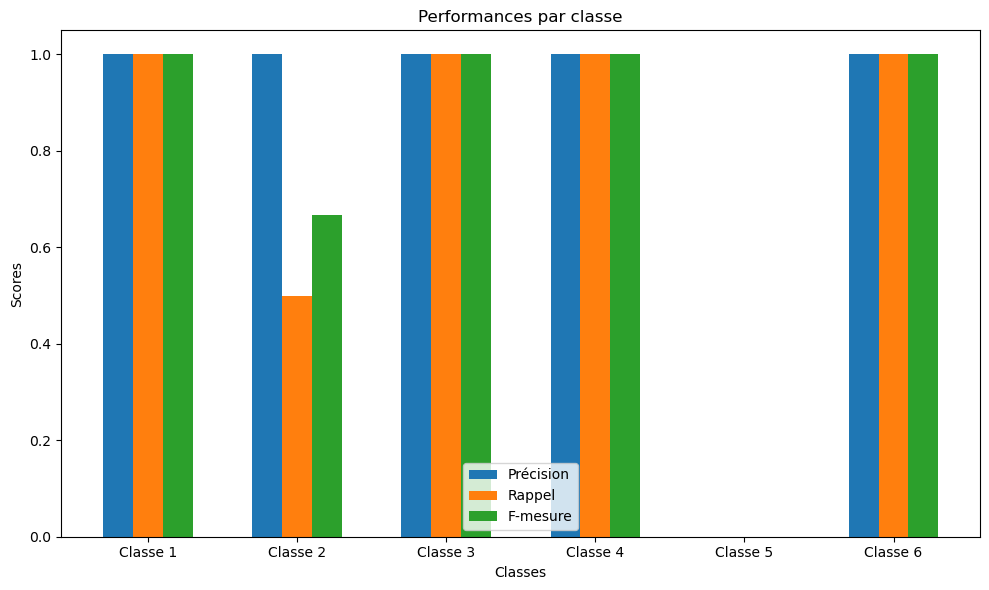

In [25]:
import matplotlib.pyplot as plt

# Supposons que vous avez calculé les métriques pour chaque classe (precision, recall, f_mesure)
# Assurez-vous que precision, recall et f_mesure sont des tableaux ou des listes contenant les valeurs pour chaque classe

classes = range(len(precision))  # Liste des classes (0, 1, 2, ...)
labels = ['Classe ' + str(i + 1) for i in classes]  # Labels pour les classes

# Visualisation de la précision, du rappel et de la F-mesure pour chaque classe
plt.figure(figsize=(10, 6))

plt.bar(classes, precision, width=0.2, align='center', label='Précision')
plt.bar([c + 0.2 for c in classes], rappel, width=0.2, align='center', label='Rappel')
plt.bar([c + 0.4 for c in classes], f_mesure, width=0.2, align='center', label='F-mesure')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Performances par classe')
plt.xticks([c + 0.2 for c in classes], labels)
plt.legend()
plt.tight_layout()

plt.show()


In [26]:
# Supposons que vous avez les prédictions (predictions_phrases) et les étiquettes réelles (etiquettes_reelles)

for i, predictions in enumerate(predictions_phrases):
    for pred, label in zip(predictions, etiquettes_reelles[i]):
        if pred != label:
            print(f"Échantillon mal prédit - Prédiction : {pred}, Étiquette réelle : {label}")


Échantillon mal prédit - Prédiction : Mpisolo, Étiquette réelle : Matoanteny


<h3>Vérification du corpus</h3>

In [27]:
from collections import Counter

# Récupérer les indices où Sokajinteny contient "Mpanoritra"
indices_mpanoritra = df[df['Sokajinteny'].apply(lambda x: 'Mpanoritra' in x)].index

# Créer un dictionnaire pour stocker les tokens de Fehezanteny associés à "Mpanoritra" dans Sokajinteny
tokens_fehezanteny_mpanoritra = {}


# Créer un compteur pour l'occurrence de chaque "Mpanoritra" dans une phrase
occurrences_mpanoritra = Counter()


# Parcourir les indices pour récupérer les tokens correspondants dans Fehezanteny
for index in indices_mpanoritra:
    sokajinteny_tokens = df.at[index, 'Sokajinteny_tokens']
    fehezanteny_tokens = df.at[index, 'Fehezanteny_tokens']
    
    # Vérifier si "Mpanoritra" est présent dans Sokajinteny_tokens
    if 'Mpanoritra' in sokajinteny_tokens:
        # Récupérer l'index de "Mpanoritra" dans Sokajinteny_tokens
        index_mpanoritra = sokajinteny_tokens.index('Mpanoritra')
        
        # Vérifier si l'index est dans la plage des tokens de Fehezanteny
        if index_mpanoritra < len(fehezanteny_tokens):
            # Ajouter le token spécifique de Fehezanteny associé à "Mpanoritra" dans le dictionnaire
            token_associated_mpanoritra = fehezanteny_tokens[index_mpanoritra]
            tokens_fehezanteny_mpanoritra[index] = token_associated_mpanoritra

            # Calculer l'occurrence de "Mpanoritra" dans la phrase et l'ajouter au compteur
            occurrences_mpanoritra[token_associated_mpanoritra] += 1
            
# Afficher les tokens spécifiques de Fehezanteny associés à "Mpanoritra" dans Sokajinteny
for index, token_fehezanteny_mpanoritra in tokens_fehezanteny_mpanoritra.items():
    print(f"Token Fehezanteny associé à 'Mpanoritra' (index {index}): {token_fehezanteny_mpanoritra}")

    
# Afficher l'occurrence de chaque "Mpanoritra" dans une phrase
print("\nOccurrence de chaque 'Mpanoritra' dans le corpus :")
for token, count in occurrences_mpanoritra.items():
    print(f"{token}: {count}")

Token Fehezanteny associé à 'Mpanoritra' (index 0): ny
Token Fehezanteny associé à 'Mpanoritra' (index 1): ny
Token Fehezanteny associé à 'Mpanoritra' (index 2): ny
Token Fehezanteny associé à 'Mpanoritra' (index 4): ny
Token Fehezanteny associé à 'Mpanoritra' (index 5): ny
Token Fehezanteny associé à 'Mpanoritra' (index 7): ny
Token Fehezanteny associé à 'Mpanoritra' (index 8): ny
Token Fehezanteny associé à 'Mpanoritra' (index 9): ny
Token Fehezanteny associé à 'Mpanoritra' (index 11): ny
Token Fehezanteny associé à 'Mpanoritra' (index 12): ny
Token Fehezanteny associé à 'Mpanoritra' (index 14): ny
Token Fehezanteny associé à 'Mpanoritra' (index 15): ny
Token Fehezanteny associé à 'Mpanoritra' (index 18): ny
Token Fehezanteny associé à 'Mpanoritra' (index 19): ny
Token Fehezanteny associé à 'Mpanoritra' (index 20): ny
Token Fehezanteny associé à 'Mpanoritra' (index 21): ary
Token Fehezanteny associé à 'Mpanoritra' (index 24): ny
Token Fehezanteny associé à 'Mpanoritra' (index 25): ny

<h3>Enregistrement du modèle</h3>

In [28]:
# Sauvegarde de model, model-mg-postal.h5 est le modèle Keras
model.save('/home/vatosoa/mg-smart-lingua-discover/data/models/model-mg-postag.h5')

# Sauvegarde de la fonction de tokenization
joblib.dump(tokenize_words, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-postag/tokenization.joblib')

# Sauvegarde des encodeurs
joblib.dump(token_encoder, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-postag/token_encoder.joblib')
joblib.dump(label_encoder, '/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-postag/label_encoder.joblib')


/home/vatosoa/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/home/vatosoa/mg-smart-lingua-discover/data/pretraining/mg-postag/label_encoder.joblib']

In [29]:
end = time.time()
print(f"Total time required for all this = {end-start}")

Total time required for all this = 1475.396703004837


In [30]:
print(start)
print(end)

1709364398.6963315
1709365874.0930345


<h3>Condition "dia" pour la prediction</h3>

In [31]:
# Prédiction sur de nouvelles phrases
nouvelles_phrases = [
    "Izy dia hitan'Andriamanitra fa tsara.",
    "Dia hitan'Andriamanitra fa tsara.",
    "Nandeha izy dia nandeha avy eo."
    #"Tsara ny nanao izao tany izao."
    # Ajoutez autant de phrases que vous le souhaitez ici
]
predictions_phrases = []
for phrase in nouvelles_phrases:
    tokens_phrase = tokenize_words(phrase)  # Tokeniser chaque nouvelle phrase séparément
    predictions_tokens = []  # Initialiser les prédictions pour cette phrase
    for i, token in enumerate(tokens_phrase):
        token_encoded = token_encoder.transform([token])[0]  # Encoder le token
        token_padded = pad_sequences([[token_encoded]], maxlen=1, padding='post')  # Rembourrer le token
        prediction_token = model.predict(token_padded)  # Prédire l'étiquette pour le token
        decoded_token = label_encoder.inverse_transform(np.argmax(prediction_token, axis=-1))

       # Ajouter la condition pour "dia"
        if token.lower() == 'dia':
            if i == 0 or i >= 2:
                # Conditions pour "dia" -> "Mpampitohy"
                predictions_tokens.append('Mpampitohy')
            else:
                # Conditions pour "dia" -> "Kianteny"
                predictions_tokens.append('Kianteny')
        else:
            predictions_tokens.append(decoded_token[0])  # Ajouter l'étiquette prédite aux prédictions de la phrase

    predictions_phrases.append(predictions_tokens)  # Ajouter les prédictions pour cette phrase

# Afficher les prédictions
for i, phrase_predictions in enumerate(predictions_phrases):
    print(f"Prédictions pour la phrase {i + 1}: {phrase_predictions}")


1/1 [==============================] - 0s 77ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 71ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 85ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 69ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 83ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 75ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 79ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 65ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 73ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 57ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 73ms/step
Prédictions pour la phrase 1: ['Mpisolo', 'Kianteny', 'Matoanteny', 'Anarana', 'Tambinteny', 'Mpamaritra']
Prédictions pour la phrase 2: ['Mpampitohy', 'Matoanteny', 'Anarana', 'Tambinteny', 'Mpamaritra']
Prédictions pour la phrase 3: ['Matoanteny', 'Mpisolo', 'Mpampitohy', 'Matoanteny', 'Mpamaritra', 'Tambinteny']


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
# Prédiction sur de nouvelles phrases
nouvelles_phrases = [
    "Izy dia hitan'Andriamanitra fa tsara.",
    "Dia hitan'Andriamanitra fa tsara.",
    "Nandeha izy dia nandeha avy eo."
    #"Tsara ny nanao izao tany izao."
    # Ajoutez autant de phrases que vous le souhaitez ici
]
predictions_phrases = []

for i, phrase in enumerate(nouvelles_phrases):
    tokens_phrase = tokenize_words(phrase)  # Tokeniser chaque nouvelle phrase séparément
    predictions_tokens = []  # Initialiser les prédictions pour cette phrase

    for j, token in enumerate(tokens_phrase):
        token_encoded = token_encoder.transform([token])[0]  # Encoder le token
        token_padded = pad_sequences([[token_encoded]], maxlen=1, padding='post')  # Rembourrer le token
        prediction_token = model.predict(token_padded)  # Prédire l'étiquette pour le token
        decoded_token = label_encoder.inverse_transform(np.argmax(prediction_token, axis=-1))
        
        # Ajouter la condition pour "dia"
        if token.lower() == 'dia':
            if j == 0 or j >= 2:
                # Conditions pour "dia" -> "Mpampitohy"
                predictions_tokens.append(f"{token}/Mpampitohy")
            else:
                # Conditions pour "dia" -> "Kianteny"
                predictions_tokens.append(f"{token}/Kianteny")
        else:
            predictions_tokens.append(f"{token}/{decoded_token[0]}")  # Ajouter l'étiquette prédite aux prédictions de la phrase

    predictions_phrases.append(f"{phrase} -> {' '.join(predictions_tokens)}")  # Ajouter les prédictions pour cette phrase

# Afficher les prédictions
for i, phrase_predictions in enumerate(predictions_phrases):
    print(f"Prédictions pour la phrase {i + 1}: {phrase_predictions}")


1/1 [==============================] - 0s 82ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 67ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 74ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 86ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 71ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 69ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 110ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 114ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 110ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 117ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 107ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 120ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 102ms/step
Prédictions pour la phrase 1: Izy dia hitan'Andriamanitra fa tsara. -> izy/Mpisolo dia/Kianteny hitan/Matoanteny andriamanitra/Anarana fa/Tambinteny tsara/Mpamaritra
Prédictions pour la phrase 2: Dia hitan'Andriamanitra fa tsara. -> dia/Mpampitohy hitan/Matoanteny andriamanitra/Anarana fa/Tambinteny tsara/Mpamaritra
Prédictions pour la phrase 3: Nandeha izy dia nandeha avy eo. -> nandeha/Matoanteny izy/Mpisolo dia/Mpampitohy nandeha/Matoanteny avy/Mpamaritra eo/Tambinteny


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<h1>Prédiction sur les données text</h1>
Mbola tsy mety ity

In [33]:
# Prédiction sur les données de test
predictions_test = model.predict(X_test_padded)

# Décodez les prédictions en étiquettes
decoded_predictions = []
for i in range(len(predictions_test)):
    decoded_sequence = []
    for j in range(len(X_test_padded[i])):
        if X_test_padded[i][j] != 0:  # Ignorez le padding
            predicted_label = np.argmax(predictions_test[i][j])
            decoded_sequence.append(label_encoder.inverse_transform([predicted_label])[0])
    decoded_predictions.append(decoded_sequence)

# Affichez quelques exemples de prédictions et leurs phrases originales
total_test_sentences = len(X_test)
print("Nombre total de phrases de test:", total_test_sentences)
for i in range(234):  # Affichez les prédictions pour les 5 premières séquences de test
    print("Exemple", i+1)
    print("Phrase d'origine:", ' '.join(X_test[i]))
    print("Prédiction:", decoded_predictions[i])
    print()


8/8 [==============================] - 3s 419ms/step
Nombre total de phrases de test: 234
Exemple 1
Phrase d'origine: dia noloaran isaka indray ny lavaka fantsakana izay voahady fony fahavelon i abrahama rainy fa efa novonoin ny filistina ireny rehefa maty abrahama ary dia nasiany anarana ireny araka ny anarana izay efa nanaovan drainy azy ihany
Prédiction: ['Mpampitohy', 'Matoanteny', 'Anarana', 'Tambinteny', 'Mpanoritra', 'Anarana', 'Anarana', 'Mpisolo', 'Matoanteny', 'Mpampitohy', 'Anarana', 'Mpanoritra', 'Anarana', 'Anarana', 'Tambinteny', 'Tambinteny', 'Matoanteny', 'Mpanoritra', 'Anarana', 'Mpisolo', 'Tambinteny', 'Matoanteny', 'Anarana', 'Mpampitohy', 'Kianteny', 'Matoanteny', 'Anarana', 'Mpisolo', 'Mpampiankina', 'Mpanoritra', 'Anarana', 'Mpisolo', 'Tambinteny', 'Matoanteny', 'Anarana', 'Mpisolo', 'Tambinteny']

Exemple 2
Phrase d'origine: dia nanaiky ny rahalahiny
Prédiction: ['Mpampitohy', 'Matoanteny', 'Mpanoritra', 'Anarana']

Exemple 3
Phrase d'origine: ary jehovah andriam

In [34]:
# Récupérer tous les tokens de Fehezanteny dans une liste
all_tokens = df['Fehezanteny_tokens'].explode().tolist()

# Convertir la liste en un ensemble (pour éliminer les doublons)
unique_tokens = set(all_tokens)

# Afficher le nombre total de mots uniques dans le corpus
total_unique_tokens = len(unique_tokens)
print("Nombre total de mots uniques dans le corpus Fehezanteny:", total_unique_tokens)

# Afficher les premiers 10 mots uniques pour vérification
print("Les mots uniques:", list(unique_tokens)[:2953])


Nombre total de mots uniques dans le corpus Fehezanteny: 2953
Les mots uniques: ['era', 'sahan', 'nahalala', 'vonjeo', 'androtrizay', 'nekeko', 'nalaza', 'aizina', 'nanafika', 'jebosita', 'mpivahiny', 'nihady', 'zava', 'sakaizany', 'mikambana', 'rahalahiko', 'mitaraina', 'havanao', 'hahalalanay', 'indreto', 'hafitoana', 'nahiratra', 'nidera', 'mitazana', 'ravehivavy', 'hatezerany', 'lahy', 'hotahina', 'hihary', 'nonina', 'manam', 'zoara', 'fandrao', 'nanolotra', 'nampandehaniny', 'nalevina', 'elaela', 'lazain', 'fetsy', 'hazon', 'nampidininy', 'meloka', 'osa', 'masirasira', 'bady', 'nihodina', 'hivelomanao', 'nihinananao', 'niverina', 'hadiniko', 'firenen', 'ony', 'ahy', 'nampisotroiny', 'mandosira', 'fisotroan', 'mihetsiketsika', 'pikola', 'masìna', 'nampifanandrifiny', 'hazany', 'mpirahalahy', 'mihebiheby', 'hampitombo', 'amboarako', 'hiely', 'hizahany', 'nampandeha', 'nampialohaviko', 'nihavian', 'nirenireny', 'jakoba', 'nohadiny', 'ampototry', 'fitanjahan', 'ranomasina', 'kerana', 

<h1>Gerer les mots inconnus??</h1>

In [35]:
fehezanteny = [
    "Mandehandeha tsara izy.",
    "Dia milalao tsara izy ireo sy ny olona rehetra.",
    "Nandeha izy dia nandeha avy eo."
    #"Tsara ny nanao izao tany izao."
    # Ajoutez autant de phrases que vous le souhaitez ici
]

predictions_phrases = []
for phrase in fehezanteny:
    tokens_phrase = tokenize_words(phrase)  # Tokeniser chaque nouvelle phrase séparément
    predictions_tokens = []  # Initialiser les prédictions pour cette phrase
    for token in tokens_phrase:
        if token in token_encoder.classes_:
            token_encoded = token_encoder.transform([token])[0]  # Encoder le token
            token_padded = pad_sequences([[token_encoded]], maxlen=1, padding='post')  # Rembourrer le token
            prediction_token = model.predict(token_padded)  # Prédire l'étiquette pour le token
            decoded_token = label_encoder.inverse_transform(np.argmax(prediction_token, axis=-1))
            predictions_tokens.append(decoded_token[0])  # Ajouter l'étiquette prédite aux prédictions de la phrase
        else:
            # Si le token est inconnu, attribuer l'étiquette "Tsy fantatra"
            predictions_tokens.append('Tsy fantatra')

    predictions_phrases.append(predictions_tokens)  # Ajouter les prédictions pour cette phrase

# Affichage des prédictions
for i, phrase in enumerate(nouvelles_phrases):
    print(f"Phrase {i + 1}: {phrase}")
    print(f"Tokens de la phrase: {tokenize_words(phrase)}")
    print(f"Prédictions pour chaque token: {predictions_phrases[i]}")
    print("\n")


1/1 [==============================] - 0s 72ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 97ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 99ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 107ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 125ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 52ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 62ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 40ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 44ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 43ms/step


/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 45ms/step
Phrase 1: Izy dia hitan'Andriamanitra fa tsara.
Tokens de la phrase: ['izy', 'dia', 'hitan', 'andriamanitra', 'fa', 'tsara']
Prédictions pour chaque token: ['Tsy fantatra', 'Mpamaritra', 'Mpisolo']


Phrase 2: Dia hitan'Andriamanitra fa tsara.
Tokens de la phrase: ['dia', 'hitan', 'andriamanitra', 'fa', 'tsara']
Prédictions pour chaque token: ['Kianteny', 'Tsy fantatra', 'Mpamaritra', 'Mpisolo', 'Mpisolo', 'Mpampitohy', 'Mpanoritra', 'Anarana', 'Mpamaritra']


Phrase 3: Nandeha izy dia nandeha avy eo.
Tokens de la phrase: ['nandeha', 'izy', 'dia', 'nandeha', 'avy', 'eo']
Prédictions pour chaque token: ['Matoanteny', 'Mpisolo', 'Kianteny', 'Matoanteny', 'Mpamaritra', 'Tambinteny']




/home/vatosoa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
